In [9]:
import pandas as pd, numpy as np, sys, scipy.stats as ss

sys.path.insert(0, '/home/croth/QTL-functions/SCRIPTS/')
import qtlfunctions as qtlfun

from sklearn import feature_selection as fs
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
## Set relative regions of MAT locus
MAT = [1529240,1661861]

## Set QTL ylabel
myylabel = '$I$ ( G$_n$, F )'

In [3]:
## Bring in centromeres datarame
cent_path = '/home/croth/Downloads/B3502/DATA/FungiDB-48_CneoformansJEC21_centromeres.csv'
centlocs = pd.read_csv(cent_path,index_col=0)
centlocs.head()

,Chromosome,Left,Right
0,1,942544,993056
1,2,860449,900038
2,3,806551,906800
3,4,222000,273992
4,5,784047,849321


In [4]:
## Bring in chromosome map
chrommap_path = '/home/croth/Downloads/B3502/DATA/chrommap.csv.gz'
chrommap = pd.read_csv(chrommap_path)
chrommap['Seqid'] = chrommap.Contig
chrommap.drop('Contig',axis=1,inplace=True)
chrommap['Chromosome'] = chrommap.index+1
chrommap = chrommap.merge(centlocs)
chrommap.tail()

,Length,Cumlen,Midpts,Seqid,Chromosome,Left,Right
9,1085720,14488944,15031804.0,AE017350.1,10,807373,880180
10,1019846,15574664,16084587.0,AE017351.1,11,144778,180133
11,906719,16594510,17047869.5,AE017352.1,12,146899,171065
12,787999,17501229,17895228.5,AE017353.1,13,121986,179214
13,762694,18289228,18670575.0,AE017356.1,14,566417,639012


In [6]:
## Bring in genotype dataframe
genopath = '../GENOTYPE/B3502_progeny_genotypes.csv.gz'
geno = pd.read_csv(genopath, index_col=0)
geno.head()

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Depth,Type,Chrom,...,A09,A15,B08,A14,B12,A13,A11,A1_af,B1_af,B7_af
1062,AE017341.1,55108,90277.00,1.0,4,CGTTGGTTTTT.GGTTTTTTTTT.GGTTGTTTTT.GGTTGTTTTTT...,11,3590,complex,1,...,3.0,3.0,3.0,1.0,2.0,2.0,1.0,0.52,0.4375,0.375
8887,AE017341.1,461149,4093.03,1.0,1,G.C,1,8658,snp,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.72,0.9375,0.875
10062,AE017341.1,530127,103609.00,1.0,1,C.G,1,7559,snp,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.56,0.5000,0.375
11653,AE017341.1,636710,88263.90,1.0,5,TGGGGGGGGGGGGGGGGGGGTTGTGCTGATG.GGGGGGGGGGGGGG...,31,1127,snp,1,...,1.0,4.0,3.0,4.0,3.0,3.0,1.0,0.04,0.0625,0.000
17357,AE017341.1,884617,62425.00,1.0,1,AGG.AGA,3,4224,snp,1,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.56,0.5625,0.500


In [7]:
geno.shape

(2624, 81)

In [6]:
geno[(geno.Chrom==2)].shape

(508, 81)

In [7]:
geno.shape[0]

2624

In [8]:
geno.groupby('Chrom').count()['Pos'].median()

25.5

In [9]:
## Bring in phenotype data from Dr. Sheng Sun
pheno = pd.read_excel('../PHENOTYPE/202011_WGS_B3502Progeny_for_QTL.xlsx')
pheno.tail()

,gDNA sample for WGS,Cross_Progeny,Basidium,Phenotype on MS (N-no filamentation; Y-filamentation; L-giant cells; T-transgressive filamentation),Notes
52,B_09,1. B3502A1_x_CF830_Random12,NaN,N,NaN
53,B_10,1. B3502A1_x_CF830_Random14,NaN,N,NaN
54,B_11,1. B3502A1_x_CF830_Random20,NaN,T,NaN
55,B_12,2. B3502B1_x_CF830_Random01,NaN,N,NaN
56,B_20 **,2. B3502B1_x_CF830_Random12,NaN,Y,"Replacing sample ""SS_20201123_H99_03"""


In [10]:
## Make a numeric map of phenotypes
unipheno = sorted(pheno[pheno.columns[3]].unique())
unipheno

['L', 'N', 'N (with rare spots of T)', 'T', 'Y']

In [11]:
## Make dict
npheno = np.array([3,0,0,2,1],dtype=float)

pdict = dict(zip(unipheno,npheno))

In [12]:
pheno['Phenotype'] = pheno[pheno.columns[3]].replace(pdict)

In [13]:
pheno['Progeny'] = [''.join(a.split("_"))[:3] for a in pheno[pheno.columns[0]]]
pheno['Parent'] = [ a.split('_')[0].split('B3502')[-1] 
                    for a in pheno['Cross_Progeny']]

pheno.index = pheno.Progeny

pheno.tail()

,gDNA sample for WGS,Cross_Progeny,Basidium,Phenotype on MS (N-no filamentation; Y-filamentation; L-giant cells; T-transgressive filamentation),Notes,Phenotype,Progeny,Parent
Progeny,,,,,,,,
B09,B_09,1. B3502A1_x_CF830_Random12,NaN,N,NaN,0.0,B09,A1
B10,B_10,1. B3502A1_x_CF830_Random14,NaN,N,NaN,0.0,B10,A1
B11,B_11,1. B3502A1_x_CF830_Random20,NaN,T,NaN,2.0,B11,A1
B12,B_12,2. B3502B1_x_CF830_Random01,NaN,N,NaN,0.0,B12,B1
B20,B_20 **,2. B3502B1_x_CF830_Random12,NaN,Y,"Replacing sample ""SS_20201123_H99_03""",1.0,B20,B1


In [14]:
## Make additional phenotype groups 
## by binning Dr Sun's scores
## Define binning dictionarys
bidict = dict(zip([0,1,2,3],[0,1,1,1]))
tridict = dict(zip([0,1,2,3],[0,1,1,2]))

## Replace scores
pheno['Binary'] = pheno.Phenotype.replace(bidict)
pheno['Tertiary'] = pheno.Phenotype.replace(tridict)


## View restuls
pheno[[pheno.columns[3],'Phenotype','Binary','Tertiary']].drop_duplicates()

,Phenotype on MS (N-no filamentation; Y-filamentation; L-giant cells; T-transgressive filamentation),Phenotype,Binary,Tertiary
Progeny,,,,
A01,N,0.0,0.0,0.0
A02,Y,1.0,1.0,1.0
A04,L,3.0,1.0,2.0
A05,N (with rare spots of T),0.0,0.0,0.0
A09,T,2.0,1.0,1.0


In [15]:
## Gather samples and unique testing sites
samples_wc = sorted(pheno.Progeny.tolist())
clone_drop = ['A44','A24'] #['A27','A43']
samples = [s for s in samples_wc if s not in clone_drop]
len(samples)

55

In [16]:
## Gather unique haplotypes for testing
loci = geno[samples].drop_duplicates()
loci.shape

(316, 55)

In [17]:
rephased = []
for i,j in loci.iterrows():
    
    cf830 = geno.loc[i,'CF830'].min()
    
    r = (j[samples] == cf830).apply(float)
    
    rephased.append(r)
    
loci2 = pd.DataFrame(rephased,index=loci.index)

In [18]:
loci2.head()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,B04,B05,B06,B07,B08,B09,B10,B11,B12,B20
1062,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
8887,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
10062,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
11653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17357,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [19]:
loci.head()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,B04,B05,B06,B07,B08,B09,B10,B11,B12,B20
1062,1.0,3.0,1.0,1.0,1.0,3.0,4.0,1.0,3.0,3.0,...,1.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,2.0,2.0
8887,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10062,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
11653,1.0,1.0,2.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,3.0,3.0,2.0,1.0,3.0,1.0
17357,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [20]:
## Here I have set the phenotype to a quadriaary phenotype
## Uncomment this to analyze a binary phenotype
## Filamentous vs nonfilamentous vs large cells
#pheno_label = 'Phenotype'
#pheno_label = 'Binary'
pheno_label = 'Tertiary'

## Copy loci df and append phenotype set above
usnps = loci2.copy().T
Y = pheno.loc[samples,pheno_label]
usnps['Y'] = Y
usnps.shape

(55, 317)

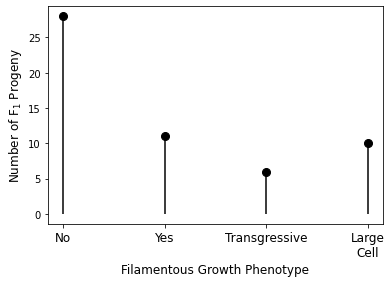

In [21]:
## Plot distribution of phenotypes
x,y = np.unique(pheno.loc[samples,'Phenotype'].values,return_counts=True)

plt.vlines(x,0,y,color='k');
plt.plot(x,y,'o',color='k',ms=8);
plt.xticks(x,['No','Yes','Transgressive','Large\nCell'],fontsize=12)
plt.xlabel('Filamentous Growth Phenotype',fontsize=12)
plt.ylabel('Number of F$_1$ Progeny',fontsize=12);
plt.savefig('../FIGURES/Filamentous_phenotypes_hist.png',
            dpi=200,bbox_inches='tight');

In [22]:
usnps.shape

(55, 317)

In [23]:
loci.shape

(316, 55)

In [24]:
## QTL MAPPING!!!
## Single locus effect
miobs = fs.mutual_info_classif(usnps.values,usnps['Y'].values,
                               discrete_features=True)
## append as column to snp dataframe
#res = usnps.T
loci['MIobs'] = miobs[:-1]

## Merge with genotype dataframe
res = geno.merge(loci)

In [25]:
## Conduct permutations
## Establish genome-wide signfiance
#thres = 0.16507851056671202
thres = 0.2523869888662186
perms = []
nperm = 1000
if thres is None:
    for i in range(nperm):
    
        y = usnps['Y'].values
        permy = np.random.permutation(y) ## Permute Y
        usnps['Y'] = permy
        MIobsp = fs.mutual_info_classif(usnps.values,permy,
                               discrete_features=True)
    
        perms.append(np.max(MIobsp[:-1]))
    
        alpha = 95 if nperm  == 1000 else 99
        thres = np.percentile(perms,alpha)

In [26]:
## Plot null distribution of association
if (thres is not None) and (len(perms)==nperm):

    plt.hist(perms,alpha=0.5,color='grey');
    plt.xlabel('$I$ ( G$_n$, F )',fontsize=12);
    plt.ylabel('# of Permutations',fontsize=12);
    plt.title('Null Distribution of Association',fontsize=12);
    plt.vlines(thres,0,nperm/6,color='r',alpha=0.5);
    plt.text(thres,nperm/6,'\u03B1 = %s'%(0.05 if alpha == 95 else 0.01),fontsize=12,
         color='k',alpha=0.5,va='bottom',ha='center')
    #plt.savefig('../FIGURES/IG_null_dist.png',
    #        dpi=100,bbox_inches='tight');

In [27]:
## Make chromsome plotting map
idxmap = list(np.arange(0,14,2)) + list(np.arange(0,14,2)+1)

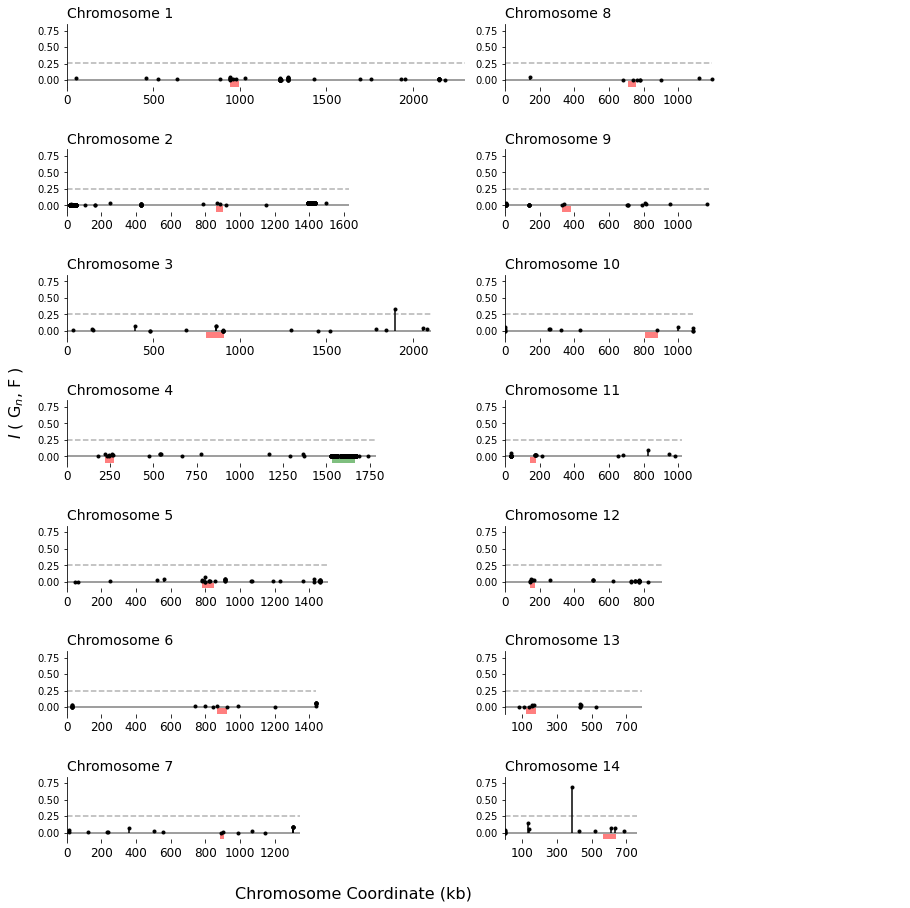

In [28]:
## Plot a Manhattan plot
fig,ax = plt.subplots(7,2,figsize=(15,15),
                      sharex=False,sharey=False)
fig.set_facecolor('w')

centy = - 0.09
centw = 10

for i,(j,c) in enumerate(chrommap.iterrows()):
    
    plt.sca(ax.ravel()[idxmap[i]])
    plt.hlines(0,0,c.Length,color='k',
               linestyle='-',alpha=0.5)
    plt.hlines(thres,0,c.Length,color='k',
               linestyle='--',alpha=0.3)
    
    
    plt.hlines(centy,c.Left,c.Right,color='r',
               linewidth=centw,alpha=0.5)
    
    if (c.Chromosome==4):
        plt.hlines(centy,*MAT,color='g',
                   linewidth=centw,alpha=0.5)
        
    temp = res[(res.Seqid==c.Seqid)]

    plt.vlines(temp.Pos,0,temp.MIobs,color='k')
    plt.plot(temp.Pos,temp.MIobs,'k.')
    plt.text(x=0,y=1,va='center',ha='left',
             s='Chromosome %s'%(i+1),fontsize=14)
    
    xp,xl = plt.xticks()
    
    xpz = xp[1:-1] if i < 12 else xp[1:-1][1::2]
    xpz = xpz[(xpz<c.Length)]
    plt.xticks(xpz,[int(x/1000) for x in xpz],
              fontsize=12)
    
    plt.xlim(0,np.max(chrommap.Length))
    plt.ylim(centy-0.01,0.85)
    plt.yticks([0,0.25,0.5,0.75])
    
    ax.ravel()[i].spines['right'].set_visible(False)
    ax.ravel()[i].spines['top'].set_visible(False)
    ax.ravel()[i].spines['bottom'].set_visible(False)

plt.subplots_adjust(wspace=0.1,hspace=1);
fig.text(0.5,0.075,'Chromosome Coordinate (kb)',
         fontsize=16,va='center',ha='right');
fig.text(0.07,0.5,myylabel,
         rotation=90,fontsize=16);

#savepath = '../FIGURES/QTL_IG_B3502_%s_filamentous_growth.png'%pheno_label
#plt.savefig(savepath,
#           dpi=200,bbox_inches='tight');
#plt.close()

#im = Image.open(savepath)
#im_crop = im.crop((0, 0, 2000, 2520))

#im_crop.save(savepath)

In [29]:
geno.shape

(2624, 81)

In [30]:
geno[(geno.Chrom==14)]

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Depth,Type,Chrom,...,A09,A15,B08,A14,B12,A13,A11,A1_af,B1_af,B7_af
432493,AE017356.1,94,2199.52,1.0,1,AATTC.CATTC,5,2095,snp,14,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.48,1.0000,1.0000
432494,AE017356.1,102,4185.15,1.0,2,TACCA.TAACA.CAACC,5,2538,snp,14,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.44,1.0000,1.0000
432515,AE017356.1,518,4337.71,1.0,1,G.C,1,19679,snp,14,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.12,0.1250,0.5000
432517,AE017356.1,852,5178.85,1.0,1,G.C,1,17792,snp,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.0625,0.5625
432538,AE017356.1,1969,4762.60,1.0,1,G.A,1,14735,snp,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.16,0.0625,0.2500
434205,AE017356.1,134798,114331.00,1.0,1,G.C,1,8199,snp,14,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.48,0.5625,0.5000
434231,AE017356.1,138916,174329.00,1.0,3,CTTGTTTTTTTTTTTTTTTTTTTTGCTTTCTCATTCCC.TTTTTTT...,39,3616,complex,14,...,1.0,1.0,1.0,2.0,1.0,1.0,2.0,0.08,0.1875,0.0000
438603,AE017356.1,388777,86252.80,1.0,1,TCAG.TCAT,4,5856,snp,14,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.52,0.5000,0.4375
439177,AE017356.1,424420,24109.70,1.0,2,CTTTTTTTTTCCTTCTTTCCCTCCG.GTTTTTTTTTCCTTCTTTCC...,25,2526,snp,14,...,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.64,0.7500,0.6250
440708,AE017356.1,517297,6863.70,1.0,1,CGGGGGGGGAGTGGCGGGGGGGGGAGCGGGCA.GGGGGGGGGAGTG...,32,2860,snp,14,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.32,0.6250,0.4375


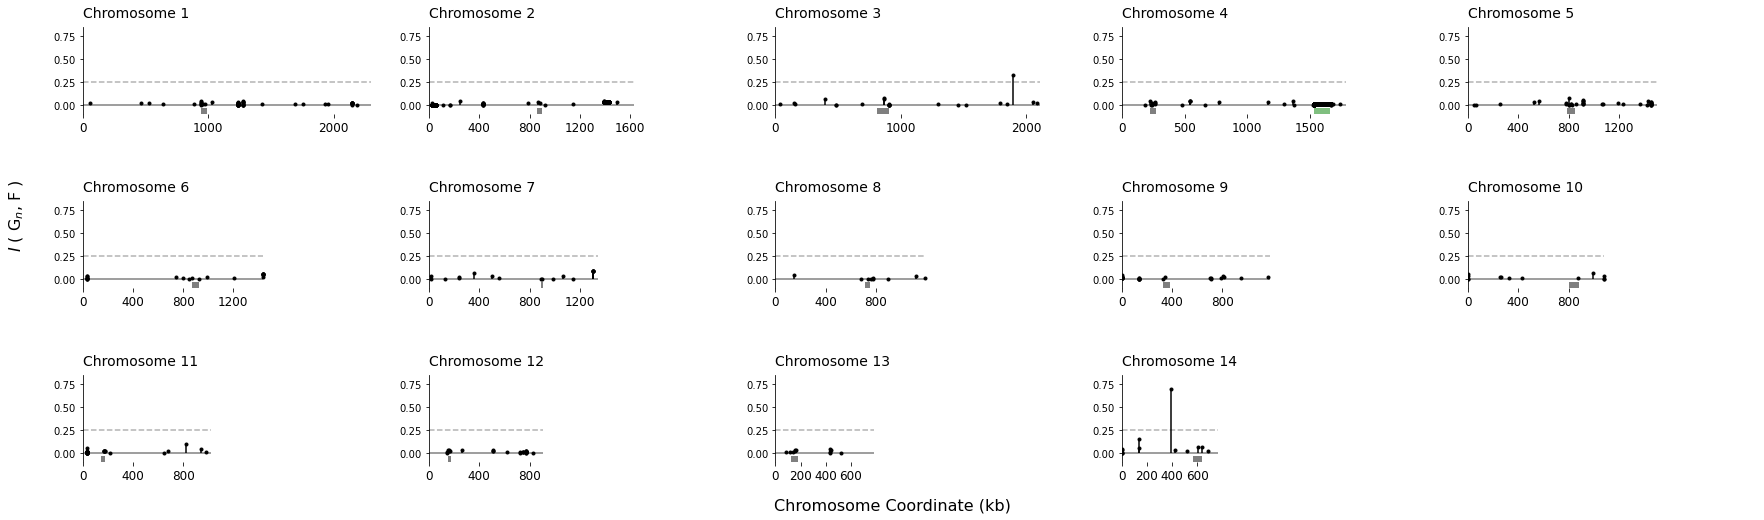

In [31]:
## Plot a Manhattan plot
fig,ax = plt.subplots(3,5,figsize=(30,8),
                      sharex=False,sharey=False)
fig.set_facecolor('w')

centy = - 0.09
centw = 10

for i,(j,c) in enumerate(chrommap.iterrows()):
    
    #plt.sca(ax.ravel()[idxmap[i]])
    plt.sca(ax.ravel()[i])
    plt.hlines(0,0,c.Length,color='k',
               linestyle='-',alpha=0.5)
    plt.hlines(thres,0,c.Length,color='k',
               linestyle='--',alpha=0.3)
    
    
    plt.hlines(centy,c.Left,c.Right,color='k',
               linewidth=centw,alpha=0.5)
    
    if (c.Chromosome==4):
        plt.hlines(centy,*MAT,color='g',
                   linewidth=centw,alpha=0.5)
        
    temp = res[(res.Seqid==c.Seqid)]

    plt.vlines(temp.Pos,0,temp.MIobs,color='k')
    plt.plot(temp.Pos,temp.MIobs,'k.')
    plt.text(x=0,y=1,va='center',ha='left',
             s='Chromosome %s'%(i+1),fontsize=14)
    
    xp,xl = plt.xticks()
    
    
    xpz = xp[1:-1][::2]
    xpz = xpz[(xpz<c.Length)]
    plt.xticks(xpz,[int(x/1000) for x in xpz],
              fontsize=12)
    
    plt.xlim(0,np.max(chrommap.Length))
    plt.ylim(centy-0.01,0.85)
    plt.yticks([0,0.25,0.5,0.75])
    
    ax.ravel()[i].spines['right'].set_visible(False)
    ax.ravel()[i].spines['top'].set_visible(False)
    ax.ravel()[i].spines['bottom'].set_visible(False)

plt.subplots_adjust(wspace=0.2,hspace=1);
fig.text(0.5,0.05,'Chromosome Coordinate (kb)',
         fontsize=16,va='center',ha='center');
fig.text(0.09,0.5,myylabel,
         rotation=90,fontsize=16);
plt.sca(ax[-1,-1]);plt.axis('off');
savepath = '../FIGURES/QTL_IG_B3502_%s_filamentous_growth_long.png'%pheno_label
plt.savefig(savepath,
           dpi=200,bbox_inches='tight');
#plt.close()

#im = Image.open(savepath)
#im_crop = im.crop((0, 0, 2000, 2520))

#im_crop.save(savepath)
#im_crop

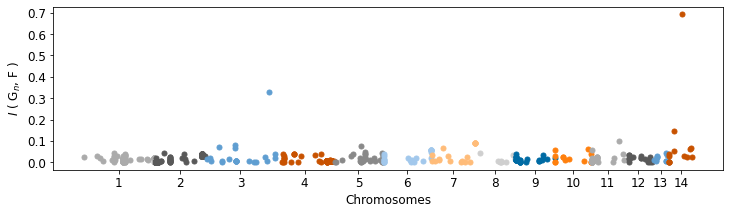

In [32]:
qtlfun.manhattan(res,pval='MIobs',ms=10,ylabel=myylabel);

In [33]:
## Find loci above threshold
sigloci = res[(res.MIobs>=thres)]
sigloci

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Depth,Type,Chrom,...,A15,B08,A14,B12,A13,A11,A1_af,B1_af,B7_af,MIobs
587,AE017343.1,1894056,119119.0,1.0,1,G.A,1,6647,snp,3,...,1.0,0.0,0.0,0.0,1.0,0.0,0.48,0.4375,0.2500,0.328123
2618,AE017356.1,388777,86252.8,1.0,1,TCAG.TCAT,4,5856,snp,14,...,1.0,0.0,0.0,0.0,1.0,0.0,0.52,0.5000,0.4375,0.692982


In [34]:
## append Genotypes of QTL and MAT
pheno.loc[pheno.index,'RIC8'] = sigloci[(sigloci.Chrom==14)][pheno.index].values[0]
pheno.loc[pheno.index,'QTL3'] = sigloci[(sigloci.Chrom==3)][pheno.index].values[0]
pheno.loc[pheno.index,'MAT'] = geno[(geno.Chrom==4) & 
                    (geno.Pos>=np.min(MAT)) & 
                    (geno.Pos<=np.max(MAT))][pheno.index].min()

In [35]:
geno[(geno.Chrom==4) & 
                    (geno.Pos>=np.min(MAT)) & 
                    (geno.Pos<=np.max(MAT))].shape

(1722, 81)

In [36]:
pheno.MAT.sum()

6.0

In [37]:
ss.pearsonr(pheno.Tertiary.values,pheno.RIC8.values)[0]**2

0.7972593507806357

In [38]:
ss.pearsonr(pheno.Tertiary.values,pheno.QTL3.values)[0]**2

0.040993610303489754

In [62]:
from matplotlib import rc

# activate latex text rendering
#rc('text', usetex=True)

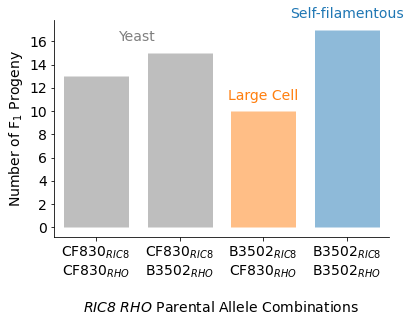

In [284]:
## Make a phenotype by genotype plot
fig,ax = plt.subplots(1,1,figsize=(6,4))
fig.set_facecolor('w')
[ax.spines[t].set_visible(False) for t in ['top','right']]

## Set ylabels
yphenos = ['Non-filamentous','Filamentous','Large Cells']
y = pheno.loc[samples,'Tertiary'].values

## Gather QTL genotypes
## QTL14 allele
ric8 = pheno.loc[samples,'RIC8']
## QTL3 allele
rho = pheno.loc[samples,'QTL3']

mycolors = ['tab:grey','tab:grey','tab:orange','tab:blue']
mylabel = [None,'Yeast','Large Cell','Self-filamentous']
c = 0

palleles = ['CF830','B3502']
newx_ticks = []

for i in [0,1]:
    for j in [0,1]:
        
        gix = (ric8==i) & (rho==j)
        #print(np.sum(gix),y[gix].min(),i+j,c,palleles[i],palleles[j])
        #plt.plot(3.75,2,'s',alpha=.5,
        #         color=mycolors[c],label=mylabel[c],ms=8)

        plt.vlines(c,0,np.sum(gix),linewidth=65,alpha=0.5,
                   color=mycolors[c])
        
        #thistick = '$RIC8_{%s}$'%palleles[i] + '\n$RHO_{%s}$'%palleles[j]
        thistick = '%s$_{RIC8}$\n%s$_{RHO}$'%(palleles[i],palleles[j])
        newx_ticks.append(thistick)
        c = c +1
#plt.plot(3.75,2,'s',color='w',ms=9)
#plt.legend(bbox_to_anchor=(1,1.25),title='Growth Phenotype',
#           markerscale=2.,ncol=3,fontsize=12,title_fontsize=12)
tx = [0.5, 2, 3]
ty = np.array([16,11,18])#-0.25
[plt.text(tx[i],ty[i],l,ha='center',fontsize=14,
          color=mycolors[i+1]) for i,l in enumerate(mylabel[1:])]

plt.yticks(np.arange(0,18,2),fontsize=14)
plt.ylabel('Number of F$_1$ Progeny',fontsize=14);
#plt.xlabel('\n'+r'\textit{RIC8} \textit{RHO} Parental Allele Combinations',fontsize=14);
plt.xlabel('\nRIC8 RHO ' + r'$\rm{Parental}$ ' + r'$\rm{Allele}$ ' + r'$\rm{Combinations}$',
           fontsize=14,fontstyle='italic')
plt.xlim(-0.5,3.5);
plt.xticks([0,1,2,3],newx_ticks,fontsize=14)
plt.savefig('../FIGURES/Filamentous_by_QTL_bar.png',
            dpi=200,bbox_inches='tight')

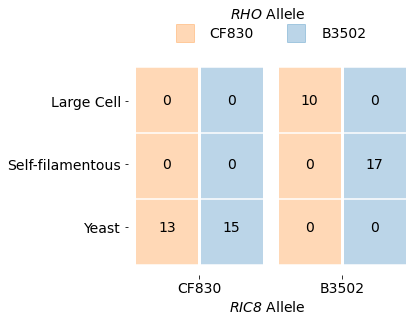

In [285]:
## Make a phenotype by genotype plot
fig,ax = plt.subplots(1,1,figsize=(5,4))
fig.set_facecolor('w')
[ax.spines[t].set_visible(False) for t in ['top','right','left','bottom']]

## Set ylabels
yphenos = ['Non-filamentous','Filamentous','Large Cells']
y = pheno.loc[samples,'Tertiary'].values

## Gather QTL genotypes
## QTL14 allele
ric8 = pheno.loc[samples,'RIC8']
## QTL3 allele
rho = pheno.loc[samples,'QTL3']

## Make boxes
ws = 0.05
bs = 0.1
#box = [(0,0.5-ws),(0.5+ws,1),(1+bs,1.5+bs-ws),(1.5+bs+ws,2+bs)]
tc = ['tab:orange','tab:blue','tab:orange','tab:blue']

[plt.vlines(k+(ws if i>1 else 0),0,1,linewidth=62,alpha=.3,color=tc[i]) 
 for i,k in enumerate(np.arange(0,1,0.25))]

[plt.hlines(k,-0.25,1,color='w') for k in np.linspace(0,1,4)]

plt.yticks(np.linspace(0.19,0.83,3),
           labels=['Yeast','Self-filamentous','Large Cell'],
          rotation=0,fontsize=14)

plt.xticks([0.125,.675],['B3502','CF830'][::-1],fontsize=14)
plt.xlabel(r'RIC8 $\rm{Allele}$',fontsize=14,fontstyle='italic');

plt.plot(1.25,0.5,'s',color='tab:orange',alpha=0.3,label='CF830')
plt.plot(1.25,0.5,'s',color='tab:blue',alpha=0.3,label='B3502')

plt.legend(bbox_to_anchor=(0.9,1.2),ncol=2,
           fontsize=14,markerscale=3,frameon=False)

plt.title(r'RHO $\rm{Allele}$',y=1.15,
          fontsize=14,fontstyle='italic');

for p,pt in enumerate([0,1,2]):
    for gt1 in [0,1]:
        for gt2 in [0,1]:
            gn = pheno[(pheno.Tertiary==pt) & 
                       (pheno.RIC8==gt1) & 
                       (pheno.QTL3==gt2) & 
                       (pheno.index.isin(samples))].shape[0]
            
            plt.text(np.arange(0,1,0.25)[gt2+(2*gt1)] + (ws if gt2+(2*gt1)>=2 else 0),
                     np.linspace(0.19,0.83,3)[p],gn,
                     va='center',ha='center',fontsize=14)
             
plt.xlim(-0.15,.925);
plt.savefig('../FIGURES/Filamentous_by_QTL_tile.png',
            dpi=200,bbox_inches='tight')

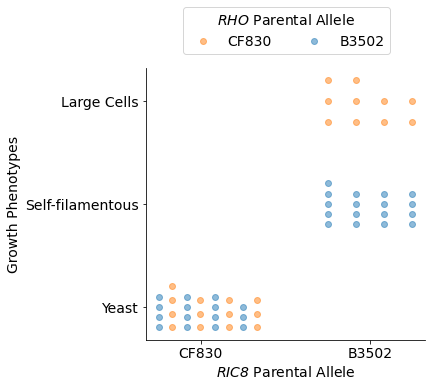

In [381]:
## Make a phenotype by genotype plot
fig,ax = plt.subplots(1,1,figsize=(5,5))
fig.set_facecolor('w')
[ax.spines[t].set_visible(False) for t in ['top','right']]

## Set ylabels
yphenos = ['Yeast','Self-filamentous','Large Cells']
y = pheno.loc[samples,'Tertiary'].values

## Gather QTL genotypes
## QTL14 allele
ric8 = pheno.loc[samples,'RIC8']
## QTL3 allele
rho = pheno.loc[samples,'QTL3']

for i in [0,1]:
    for j in [0,1]:
        gix = (ric8==i) & (rho==j)
        
                
        xjitter = np.linspace(-0.25,0.25,4) + ric8[gix].min() + (0.08 if i+j == 0 else 0)
        yjitter = np.linspace(-0.2,0.2,int(np.round(np.sum(gix)/4,0)+1)) + y[gix].min()
        
        myjit = np.concatenate([[(x,y) for x in xjitter] for y in yjitter])[:np.sum(gix)]
            
        
        plt.plot(*myjit.T,'o',alpha= .5,
                 label = ['CF830','B3502'][j] if i ==0 else None,
                     color='tab:orange' if j == 0 else 'tab:blue')
            
plt.legend(loc=0,frameon=True,ncol=2,bbox_to_anchor=(.9,1.25),
           title='$RHO$ Parental Allele',
           fontsize=14,title_fontsize=14)
plt.yticks(sorted(np.unique(y)),yphenos,fontsize=14)
plt.ylabel('Growth Phenotypes',fontsize=14);
plt.xticks([0,1],['B3502','CF830'][::-1],fontsize=14)
plt.xlabel('RIC8 ' +r'$\rm{Parental}$ ' + r'$\rm{Allele}$',
           fontsize=14,fontstyle='italic');
plt.savefig('../FIGURES/Filamentous_by_QTL_dot.png',
            dpi=200,bbox_inches='tight')

In [47]:
gffpath = '/home/croth/Downloads/B3502/REF/FungiDB-48_CneoformansJEC21.gff.gz'
gff = qtlfun.loadgff(gffpath)
gff.head()

,Seqid,Source,Type,Start,End,Score,Strand,Phase,Attribute,Parent,Gene
0,AE017352.1,VEuPathDB,gene,713524,714773,.,-1,.,ID=CNL06190;description=aldo-keto reductase%2C...,CNL06190,CNL06190
1,AE017352.1,VEuPathDB,mRNA,713524,714773,.,-1,.,ID=CNL06190-t26_1;Parent=CNL06190;description=...,CNL06190,CNL06190
2,AE017352.1,VEuPathDB,exon,713524,713666,.,-1,.,ID=exon_CNL06190-E5;Parent=CNL06190-t26_1,CNL06190-t26_1,CNL06190
3,AE017352.1,VEuPathDB,exon,713720,713815,.,-1,.,ID=exon_CNL06190-E4;Parent=CNL06190-t26_1,CNL06190-t26_1,CNL06190
4,AE017352.1,VEuPathDB,exon,713866,714350,.,-1,.,ID=exon_CNL06190-E3;Parent=CNL06190-t26_1,CNL06190-t26_1,CNL06190


In [48]:
##gff[(gff.Seqid==sigloci.T[485].Seqid) & 
#    (gff.Start<=sigloci.T[485].Pos) & 
#    (gff.End>=sigloci.T[485].Pos)]

In [49]:
gene_changes = pd.read_csv('/home/croth/Downloads/B3502/DATA/gene_changes.csv.gz')

In [50]:
gene_changes.Strain.unique()

array(['B3502_A1_Stock1', 'B3502_A7_Stock2', 'B3502_B1_Stock3',
       'B3502_B7_Stock4', 'B3502_C1_Stock7', 'B3502_D1_Stock6', 'CF830',
       'JEC20', 'JEC21', 'B3502_C1_Stock5'], dtype=object)

In [51]:
gene_changes[(gene_changes.Gene=='CNC06490') & 
             (gene_changes.Strain.isin(
                 ['B3502_A1_Stock1',
                  'B3502_B1_Stock3',
                  'B3502_B7_Stock4',
                  'CF830']))]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chromosome,Seqid,Start,End,Strand,Description
365,B3502_A1_Stock1,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
367,B3502_B1_Stock3,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
368,B3502_B7_Stock4,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
372,CF830,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,0,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator


In [52]:
gff[(gff.Gene=='CNC06490') & (gff.Type=='CDS')].shape

(5, 11)

In [53]:
## How corrilated are these loci
sigloci[samples].T.corr(method='spearman')

,587,2618
587,1.000000,0.095183
2618,0.095183,1.000000


In [54]:
## how correlated is the chromosome 14 variants
res[(res.Chrom==14)][samples].T.corr()

,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620,2621,2622,2623
2611,1.000000,0.835176,-0.208791,-0.244600,0.216641,0.158971,-0.039811,0.052920,0.051759,-0.144346,0.043679,0.144346,-0.033610
2612,0.835176,1.000000,-0.224855,-0.260462,0.156780,0.068337,0.058187,-0.027299,0.063041,-0.192625,-0.007661,0.041277,-0.034008
2613,-0.208791,-0.224855,1.000000,0.331957,-0.014723,0.073251,0.106164,0.138526,-0.106394,-0.058052,-0.148507,-0.028242,0.108587
2614,-0.244600,-0.260462,0.331957,1.000000,0.170547,-0.089205,-0.075955,-0.029696,-0.082292,-0.127220,0.083333,0.127220,0.098653
2615,0.216641,0.156780,-0.014723,0.170547,1.000000,0.073383,-0.038100,-0.237734,0.104022,0.007207,0.060193,-0.007207,-0.026722
2616,0.158971,0.068337,0.073251,-0.089205,0.073383,1.000000,-0.254086,0.527153,-0.113784,0.048065,-0.252748,0.098801,0.063802
2617,-0.039811,0.058187,0.106164,-0.075955,-0.038100,-0.254086,1.000000,-0.270666,-0.062505,0.028421,-0.075955,-0.028421,-0.131131
2618,0.052920,-0.027299,0.138526,-0.029696,-0.237734,0.527153,-0.270666,1.000000,0.096527,0.089336,-0.274685,0.277342,0.303210
2619,0.051759,0.063041,-0.106394,-0.082292,0.104022,-0.113784,-0.062505,0.096527,1.000000,0.139179,-0.157727,0.064047,-0.097420
2620,-0.144346,-0.192625,-0.058052,-0.127220,0.007207,0.048065,0.028421,0.089336,0.139179,1.000000,0.037418,-0.112903,-0.296786


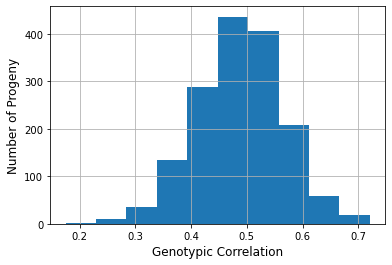

In [55]:
## Find clones
loci = geno[samples_wc].drop_duplicates()
segcors = []
for i,s1 in enumerate(samples_wc):
    for j,s2 in enumerate(samples_wc):
        
        if i>j:
            cs = loci[[s1,s2]].corr().values[0][-1]
            segcors.append((s1,s2,cs))
        else:
            pass
segcors = pd.DataFrame(segcors,columns=['S1','S2','Cor'])

## Display histogram of genetic correlations
segcors.Cor.hist();
plt.ylabel('Number of Progeny',fontsize=12)
plt.xlabel('Genotypic Correlation',fontsize=12);

In [56]:
## Find clones
clones = segcors[(segcors.Cor>.8)]
clones

,S1,S2,Cor


In [57]:
## View data of clone group 2
pheno[(pheno.Strain.isin(clones.values[1][:-1]))]

AttributeError: 'DataFrame' object has no attribute 'Strain'

In [ ]:
## Samples with transgressive filamentation
pheno[(pheno.Phenotype==2)]

In [ ]:
## Check phenotype of progeny with duplicated chromosome 11
pheno[(pheno.Strain=='A03')]

In [ ]:
## how many unique loci combos
((usnps.shape[1] - 1)**2 - (59))/2

In [ ]:
## Looks like there may be SNPS near or in centromeres
for i,c in chrommap.iterrows():
    temp = geno[(geno.Chromosome==c.Chromosome) & 
                (geno.Pos>=c.Left) & (geno.Pos<=c.Right)]
    if temp.shape[0]>0:
        print(temp[['Pos','Chromosome','Alleles']])
        print('\n')
    else:
        pass

In [ ]:
## Phenotype
Y = pheno.loc[samples,'Tertiary'].values.reshape(-1,1)

## Main loci to test
ssk1 = pheno.loc[samples,'MAT'].values.reshape(-1,1)
ssk2 = pheno.loc[samples,'QTL3'].values.reshape(-1,1)
ric8 = pheno.loc[samples,'RIC8'].values.reshape(-1,1)

# encode two- and three-locus genotypes
ssk1ssk2 = ssk1 + 2 * ssk2
ssk1ric8 = ssk1 + 2 * ric8
ssk2ric8 = ssk2 + 2 * ric8
ssk1ssk2ric8 = ssk1 + 2*ssk2 + 4*ric8

MIobs = fs.mutual_info_classif(np.hstack((Y,
                                  ssk1,ssk2,ric8,
                                  ssk1ssk2, ssk1ric8, ssk2ric8,
                                  ssk1ssk2ric8)), Y.ravel(),
                      discrete_features=True)

# label MIs
MI_ssk1 = MIobs[1]
MI_ssk2 = MIobs[2]
MI_ric8 = MIobs[3]
MI_ssk1ssk2 = MIobs[4]
MI_ssk1ric8 = MIobs[5]
MI_ssk2ric8 = MIobs[6]
MI_ssk1ssk2ric8 = MIobs[7]

entropy_Y = MIobs[0]

# IGstrict of Hu et al
IG_ssk1ssk2 = MI_ssk1ssk2 - MI_ssk1 - MI_ssk2
IG_ssk1ric8 = MI_ssk1ric8 - MI_ssk1 - MI_ric8
IG_ssk2ric8 = MI_ssk2ric8 - MI_ssk2 - MI_ric8
IG_ssk1ssk2ric8 =  MI_ssk1ssk2ric8 - np.maximum(IG_ssk1ssk2, 0) \
    - np.maximum(IG_ssk1ric8,0) \
    - np.maximum(IG_ssk2ric8, 0) \
    - MI_ssk1 - MI_ssk2 - MI_ric8

In [ ]:
MIperm = []

for i in range(1000):
    origgenos = np.hstack((ssk1,ssk2,ric8))
    permgenos = np.random.permutation(origgenos)
    pssk1 = permgenos[:,0]
    pssk2 = permgenos[:,1]
    pric8 = permgenos[:,2]
    pssk1 = pssk1.reshape(-1,1)
    pssk2 = pssk2.reshape(-1,1)
    pric8 = pric8.reshape(-1,1)
    pssk1ssk2 = pssk1 + 2*pssk2
    pssk1ric8 = pssk1 + 2*pric8
    pssk2ric8 = pssk2 + 2*pric8
    pssk1ssk2ric8 = pssk1 + 2*pssk2 + 4*pric8    
    
    miperm = fs.mutual_info_classif(np.hstack((Y,
                                  pssk1,pssk2,pric8)), Y.ravel(),
                      discrete_features=True)
    MIperm.append(miperm)
    
    
MIperm = np.array(MIperm)
    
MI_pssk1 = MIperm[:,1]
MI_pssk2 = MIperm[:,2]
MI_pric8 = MIperm[:,3]

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
fig.set_facecolor('w')

plt.sca(ax[0])
plt.hist(MI_pssk1,color='grey',alpha=0.5)
plt.vlines(MI_ssk1, ymin=0, ymax=200, color='r')
plt.title("MI_$MAT$: %s\np-value: %s"%(
            str(np.round(MI_ssk1,3)),
            str(np.round(np.sum(MI_pssk1 > MI_ssk1)/float(len(MI_pssk1)),3))),
         fontsize=12)
plt.ylabel('Number of Permutations',fontsize=12)
      

plt.sca(ax[1])
plt.hist(MI_pssk2,color='tab:blue',alpha=0.5)
plt.vlines(MI_ssk2, ymin=0, ymax=200, color='r')
plt.title("MI_$RHO$: %s\np-value: %s"%(
            str(np.round(MI_ssk2,3)),
            str(np.round(np.sum(MI_pssk2 > MI_ssk2)/float(len(MI_pssk2)),3))),
         fontsize=12)
#print("MI_QTL3: ", MI_ssk2, "p-value: ", 
#      np.sum(MI_pssk2 > MI_ssk2)/float(len(MI_pssk2)))

plt.sca(ax[2])
plt.hist(MI_pric8,color='tab:orange',alpha=0.5)
plt.vlines(MI_ric8, ymin=0, ymax=200, color='r')
plt.title("MI_$RIC8$: %s\np-value: %s"%(
            str(np.round(MI_ric8,3)),
            str(np.round(np.sum(MI_pric8 > MI_ric8)/float(len(MI_pric8)),3))),
         fontsize=12)
#print("MI_ric8: ", MI_ric8, "p-value: ", 
#      np.sum(MI_pric8 > MI_ric8)/float(len(MI_pric8)))
fig.text(x=0.5,y=-0.05,s='Single Loci (Mutual Information)',
         fontsize=12,va='center',ha='center')
plt.savefig('../FIGURES/Filamentous_Main_effects.png',
           dpi=100,bbox_inches='tight');

In [ ]:
MIperm = []

for i in range(1000):
    origgenos = np.hstack((ssk1,ssk2,ric8))
    
    p0ssk1 = np.random.permutation(ssk1[Y==0])
    p1ssk1 = np.random.permutation(ssk1[Y==1])
    p2ssk1 = np.random.permutation(ssk1[Y==2])
    pssk1 = np.hstack((p0ssk1,p1ssk1,p2ssk1))
    
    p0ssk2 = np.random.permutation(ssk2[Y==0])
    p1ssk2 = np.random.permutation(ssk2[Y==1])
    p2ssk2 = np.random.permutation(ssk2[Y==2])
    pssk2 = np.hstack((p0ssk2,p1ssk2, p2ssk2))    
    
    p0ric8 = np.random.permutation(ric8[Y==0])
    p1ric8 = np.random.permutation(ric8[Y==1]) 
    p2ric8 = np.random.permutation(ric8[Y==2])     
    pric8 = np.hstack((p0ric8,p1ric8,p2ric8)) 
    
    pY = np.array([0]*len(p0ssk1) + [1]*len(p1ssk1) + [2]*len(p2ssk1))
                     
    pY = pY.reshape(-1,1)
    pssk1 = pssk1.reshape(-1,1)
    pssk2 = pssk2.reshape(-1,1)
    pric8 = pric8.reshape(-1,1)
    
    pssk1ssk2 = pssk1 + 2*pssk2
    pssk1ric8 = pssk1 + 2*pric8
    pssk2ric8 = pssk2 + 2*pric8
    pssk1ssk2ric8 = pssk1 + 2*pssk2 + 4*pric8    
    
    miperm = fs.mutual_info_classif(np.hstack((pY,
                                  pssk1, pssk2, pric8,
                                  pssk1ssk2, pssk1ric8, pssk2ric8,
                                  pssk1ssk2ric8)), pY.ravel(),
                      discrete_features=True)
    MIperm.append(miperm)
    
MIperm = np.array(MIperm)
    
MI_pssk1 = MIperm[:,1]
MI_pssk2 = MIperm[:,2]
MI_pric8 = MIperm[:,3]
MI_pssk1ssk2 = MIperm[:,4]
MI_pssk1ric8 = MIperm[:,5]
MI_pssk2ric8 = MIperm[:,6]
MI_pssk1ssk2ric8 = MIperm[:,7]

zeros = np.zeros_like(MI_pssk1)

# IGstrict for permuted data
IG_pssk1ssk2 = MI_pssk1ssk2 - MI_pssk1 - MI_pssk2
IG_pssk1ric8 = MI_pssk1ric8 - MI_pssk1 - MI_pric8
IG_pssk2ric8 = MI_pssk2ric8 - MI_pssk2 - MI_pric8
IG_pssk1ssk2ric8 =  MI_pssk1ssk2ric8 - np.maximum(IG_pssk1ssk2, zeros) \
    - np.maximum(IG_pssk1ric8, zeros) \
    - np.maximum(IG_pssk2ric8, zeros) \
    - MI_pssk1 - MI_pssk2 - MI_pric8


In [ ]:
np.min(IG_pssk2ric8)

In [ ]:
IG_ssk2ric8

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
fig.set_facecolor('w')

plt.sca(ax[0])
plt.hist(IG_pssk1ssk2,color='grey',alpha=0.5)
plt.vlines(IG_ssk1ssk2, ymin=0, ymax=200, color='r')
plt.ylabel('Number of Permutations',fontsize=12)
k = np.sum(IG_pssk1ssk2 > IG_ssk1ssk2)/float(len(IG_pssk1ssk2))
plt.title("IG_$MAT$ $RHO$: %s\np-value: %s"%(
    str(np.round(IG_ssk1ssk2,4)),
    str(np.round(k,4))),fontsize=12)

#print("IG_MATQTL3: ", IG_ssk1ssk2, "p-value: ", 
#      np.sum(IG_pssk1ssk2 > IG_ssk1ssk2)/float(len(IG_pssk1ssk2)))

plt.sca(ax[1])
plt.hist(IG_pssk1ric8,color='grey',alpha=0.5)
plt.vlines(IG_ssk1ric8, ymin=0, ymax=200, color='r')
k = np.sum(IG_pssk1ric8 > IG_ssk1ric8)/float(len(IG_pssk1ric8))
plt.title("IG_$MAT$ $RIC8$: %s\np-value: %s"%(
    str(np.round(IG_ssk1ric8,4)),
    str(np.round(k,4))),fontsize=12)
#print("IG_MATric8: ", IG_ssk1ric8, "p-value: ", 
#      np.sum(IG_pssk1ric8 > IG_ssk1ric8)/float(len(IG_pssk1ric8)))

plt.sca(ax[2])
plt.hist(IG_pssk2ric8,color='grey',alpha=0.5)
plt.vlines(IG_ssk2ric8, ymin=0, ymax=200, color='r')
k = np.sum(IG_pssk2ric8 > IG_ssk2ric8)/float(len(IG_pssk2ric8))
plt.title("IG_$RHO$ $RIC8$: %s\np-value: %s"%(
    str(np.round(IG_ssk2ric8,4)),
    str(np.round(k,4))),fontsize=12)

#print("IG_QTL3ric8: ", IG_ssk2ric8, "p-value: ", 
#      np.sum(IG_pssk2ric8 > IG_ssk2ric8)/float(len(IG_pssk2ric8)))

fig.text(x=0.5,y=-0.05,s='Two Loci (Information Gain)',
         fontsize=12,va='center',ha='center')
plt.savefig('../FIGURES/Filamentous_Epistatic_effects.png',
           dpi=100,bbox_inches='tight');

In [ ]:
plt.hist(IG_pssk1ssk2ric8)
plt.vlines(IG_ssk1ssk2ric8, ymin=0, ymax=200, color='r')
print("IG_MATQTL3ric8: ", IG_ssk1ssk2ric8, "p-value: ", 
      np.sum(IG_pssk1ssk2ric8 > IG_ssk1ssk2ric8)/float(len(IG_pssk1ssk2ric8)))
pass

## Phenotype
Y = pheno.loc[samples,'Tertiary'].values.reshape(-1,1)

## Main loci to test
mat = pheno.loc[samples,'MAT'].values.reshape(-1,1)
qtl3 = pheno.loc[samples,'QTL3'].values.reshape(-1,1)
ric8 = pheno.loc[samples,'RIC8'].values.reshape(-1,1)

## Secondary effects
qtl3mat = qtl3 + 2*mat
matric8 = mat + 2*ric8
qtl3ric8 = qtl3 + 2*ric8

## Three way epistasis
matqtl3ric8 = mat + 2*qtl3 + 4*ric8

MIobs = fs.mutual_info_classif(np.hstack((Y,
                                  qtl3,mat,ric8,
                                  qtl3mat,matric8,qtl3ric8,
                                  matqtl3ric8)), Y.ravel(),
                                  discrete_features=True)

# label MIs
entropy_y = MIobs[0]

MI_qtl3 = MIobs[1]
MI_mat = MIobs[2]
MI_ric8 = MIobs[3]

MI_qtl3mat = MIobs[4]
MI_matric8 = MIobs[5]
MI_qtl3ric8 = MIobs[6]

MI_matqtl3ric8 = MIobs[7]

# IGstrict of Hu et al
IG_qtl3mat = MI_qtl3mat - MI_qtl3 - MI_mat
IG_matric8 = MI_matric8 - MI_mat - MI_ric8
IG_qtl3ric8 = MI_qtl3ric8 - MI_qtl3 - MI_ric8
IG_matqtl3ric8 =  MI_matqtl3ric8 - np.maximum(IG_qtl3mat, 0) \
    - np.maximum(IG_matric8,0) \
    - np.maximum(IG_qtl3ric8, 0) \
    - MI_qtl3 - MI_mat - MI_ric8